In [2]:
import glob
from pickle import load
trainings = list()
filelist = list(glob.glob('results*.pickle'))
for file in filelist:
    trainings.append(load(open(file, 'rb')))

In [2]:
len(trainings[0][0])

1

{'channels': 14, 'depth': 1, 'dim': 64, 'dim_head': 32, 'dropout': 0.2, 'emb_dropout': 0, 'heads': 8, 'image_size': (1, 300), 'mlp_dim': 128, 'num_classes': 8, 'patch_size': (1, 10), 'pool': 'cls', 'pretrained': 'vit_dim64_h8_1_1_epoch100.pth', 'sessions': 5, 'subjects': 2, 'training_config': {'epochs': 200, 'batch_size': 64, 'optim': 'Adam', 'optim_hparams': {'lr': 0, 'betas': (0.9, 0.999), 'weight_decay': 0}, 'lr_scheduler': 'CyclicLR', 'lr_scheduler_hparams': {'base_lr': 1e-07, 'max_lr': 0.001, 'step_size_up': 150, 'step_size_down': None, 'mode': 'triangular', 'cycle_momentum': False}}, 'use_cls_token': True}
200 0
0.676613712310791 [0.69281445 0.66041303] 0.6926690340042114 0.5307701826095581


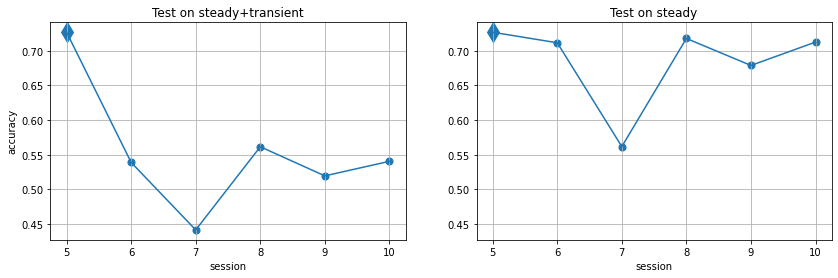

{'channels': 14, 'depth': 1, 'dim': 64, 'dim_head': 32, 'dropout': 0.2, 'emb_dropout': 0, 'heads': 8, 'image_size': (1, 300), 'mlp_dim': 128, 'num_classes': 8, 'patch_size': (1, 10), 'pool': 'cls', 'pretrained': 'vit_dim64_h8_1_1_epoch100.pth', 'sessions': 5, 'subjects': 2, 'training_config': {'epochs': 200, 'batch_size': 64, 'optim': 'Adam', 'optim_hparams': {'lr': 0, 'betas': (0.9, 0.999), 'weight_decay': 0}, 'lr_scheduler': 'CyclicLR', 'lr_scheduler_hparams': {'base_lr': 1e-07, 'max_lr': 0.001, 'step_size_up': 150, 'step_size_down': None, 'mode': 'triangular', 'cycle_momentum': False}}, 'use_cls_token': True}
200 0
0.5935703754425049 [0.62498999 0.56215076] 0.6248196959495544 0.43864837288856506


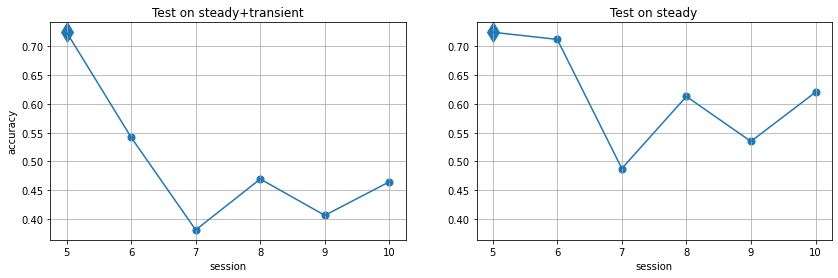

{'channels': 14, 'depth': 1, 'dim': 64, 'dim_head': 32, 'dropout': 0.2, 'emb_dropout': 0, 'heads': 8, 'image_size': (1, 300), 'mlp_dim': 128, 'num_classes': 8, 'patch_size': (1, 10), 'pool': 'cls', 'pretrained': 'vit_dim64_h8_1_1_epoch100.pth', 'sessions': 5, 'subjects': 2, 'training_config': {'epochs': 0, 'batch_size': 64, 'optim': 'Adam', 'optim_hparams': {'lr': 0.001, 'betas': (0.9, 0.999), 'weight_decay': 0}, 'lr_scheduler': 'StepLR', 'lr_scheduler_hparams': {'gamma': 0.1, 'step_size': 1}}, 'use_cls_token': True}
0 0.001
0.5916847109794616 [0.61356792 0.56980147] 0.6134050488471985 0.4710546135902405


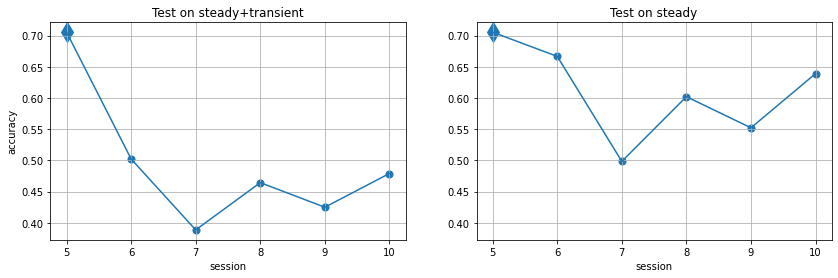

In [12]:
# Problemi:
# - preso modello ultima epoca e non il migliore
# - val acc calcolata sempre su steady e non anche su non steady
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

n_idx = 0

for configs, results_ in trainings:
    
    for config, r in zip(configs, results_):
        print(config)
        print(config['training_config']['epochs'], config['training_config']['optim_hparams']['lr'])

        acccs = []
        acccs_steady = []

        #mpl.rcParams['axes.prop_cycle'] = mpl.cycler("color", ["#000000", '#000000'])
        fix, (ax1, ax2) = plt.subplots(figsize=(14, 4), ncols=2)
        ax1.grid(True)
        ax2.grid(True)
        ax1.set_title("Test on steady+transient")
        ax2.set_title("Test on steady")


        accs = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs /= 2

        accs_steady = np.array([0] * len(r['test_sessions']), dtype=float)
        accs_steady_ = np.array([0, 0], dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
            accs_steady_[0] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
            accs_steady_[1] += (y_pred == y_true).sum().float() / len(y_true)
        accs_steady /= 2
        accs_steady_ /= 5

        acc_val = .5 * r['val-fold_0']['losses_accs'][-1]['val_acc'] + .5 * r['val-fold_1']['losses_accs'][-1]['val_acc']
        #acc_val =  r['val-fold_0']['losses_accs'][-1]['val_acc']

        y = [acc_val] + [a for a in accs]
        acccs.append(y)

        y = [acc_val] + [a for a in accs_steady]
        acccs_steady.append(y)


        acccs = np.array(acccs).mean(axis=0)
        acccs_steady = np.array(acccs_steady).mean(axis=0)

        x = [r['test_sessions'][0]] + [a for a in np.array(r['test_sessions']) + 1]
        y1 = [a for a in acccs]
        y2 = [a for a in acccs_steady]
        m = ['d'] + (['o'] * (len(x) - 1))
        s = [200] + [50] * (len(x) - 1)

        ax1.plot(x, y1, color=f'C{n_idx}')
        for xp, yp, m_, s_ in zip(x, y1, m, s):
            ax1.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C{n_idx}')

        ax2.plot(x, y2, color=f'C{n_idx}')
        for xp, yp, m_, s_ in zip(x, y2, m, s):
            ax2.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C{n_idx}')


        (min1, max1), (min2, max2) = ax1.get_ylim(), ax2.get_ylim()
        min_ = min(min1, min2)
        max_ = max(max1, max2)
        ax1.set_ylim((min_, max_))
        ax2.set_ylim((min_, max_))

        ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        ax1.set_xlabel("session")
        ax2.set_xlabel("session")
        ax1.set_ylabel("accuracy")

        print(np.array(acccs_steady)[1:].mean(), accs_steady_, r['val-fold_0']['losses_accs'][-1]['test_acc'], r['val-fold_1']['losses_accs'][-1]['test_acc'])

        plt.show()

{'channels': 14, 'depth': 1, 'dim': 64, 'dim_head': 32, 'dropout': 0.2, 'emb_dropout': 0, 'heads': 8, 'image_size': (1, 300), 'mlp_dim': 128, 'num_classes': 8, 'patch_size': (1, 10), 'pool': 'cls', 'pretrained': 'vit_dim64_h8_1_1_epoch100.pth', 'sessions': 5, 'subjects': 2, 'training_config': {'epochs': 200, 'batch_size': 64, 'optim': 'Adam', 'optim_hparams': {'lr': 0, 'betas': (0.9, 0.999), 'weight_decay': 0}, 'lr_scheduler': 'CyclicLR', 'lr_scheduler_hparams': {'base_lr': 1e-07, 'max_lr': 0.001, 'step_size_up': 150, 'step_size_down': None, 'mode': 'triangular', 'cycle_momentum': False}}, 'use_cls_token': True}
200 0


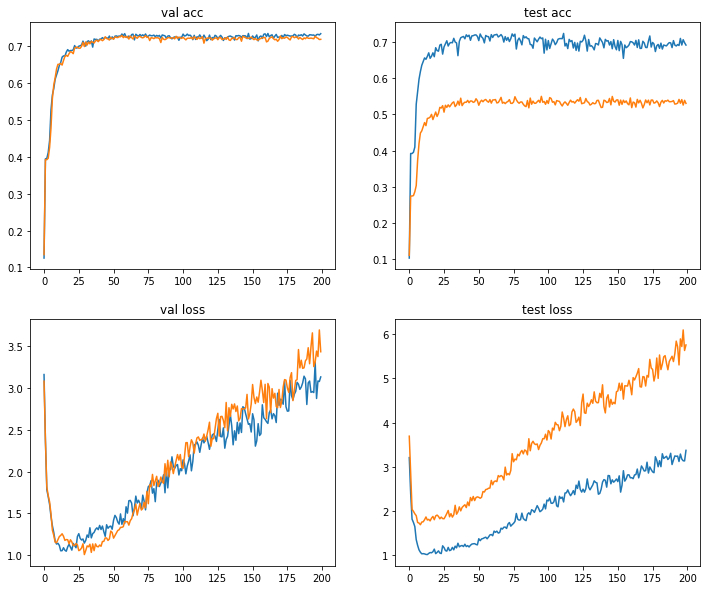

{'channels': 14, 'depth': 1, 'dim': 64, 'dim_head': 32, 'dropout': 0.2, 'emb_dropout': 0, 'heads': 8, 'image_size': (1, 300), 'mlp_dim': 128, 'num_classes': 8, 'patch_size': (1, 10), 'pool': 'cls', 'pretrained': 'vit_dim64_h8_1_1_epoch100.pth', 'sessions': 5, 'subjects': 2, 'training_config': {'epochs': 200, 'batch_size': 64, 'optim': 'Adam', 'optim_hparams': {'lr': 0, 'betas': (0.9, 0.999), 'weight_decay': 0}, 'lr_scheduler': 'CyclicLR', 'lr_scheduler_hparams': {'base_lr': 1e-07, 'max_lr': 0.001, 'step_size_up': 150, 'step_size_down': None, 'mode': 'triangular', 'cycle_momentum': False}}, 'use_cls_token': True}
200 0


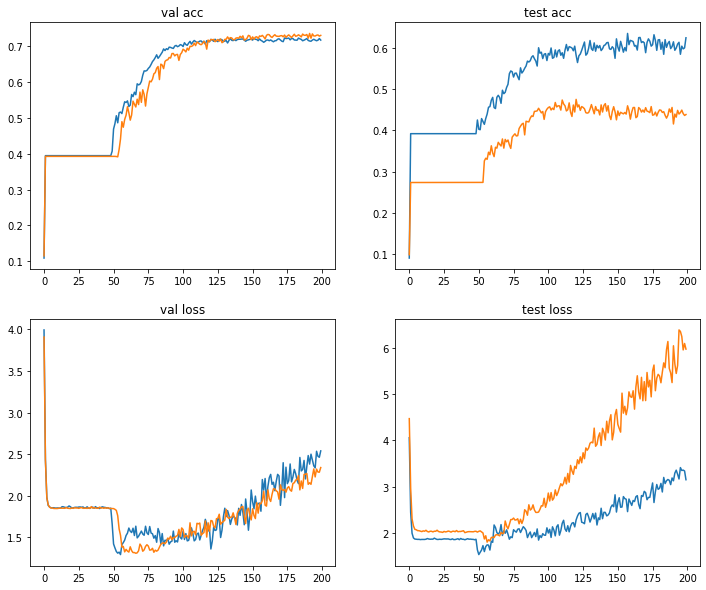

{'channels': 14, 'depth': 1, 'dim': 64, 'dim_head': 32, 'dropout': 0.2, 'emb_dropout': 0, 'heads': 8, 'image_size': (1, 300), 'mlp_dim': 128, 'num_classes': 8, 'patch_size': (1, 10), 'pool': 'cls', 'pretrained': 'vit_dim64_h8_1_1_epoch100.pth', 'sessions': 5, 'subjects': 2, 'training_config': {'epochs': 0, 'batch_size': 64, 'optim': 'Adam', 'optim_hparams': {'lr': 0.001, 'betas': (0.9, 0.999), 'weight_decay': 0}, 'lr_scheduler': 'StepLR', 'lr_scheduler_hparams': {'gamma': 0.1, 'step_size': 1}}, 'use_cls_token': True}
0 0.001


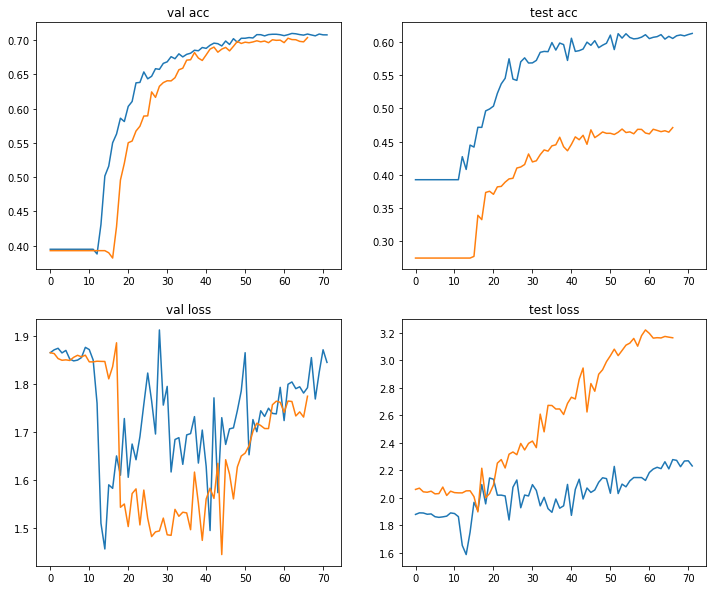

In [4]:
for configs, results_ in trainings:
    
    for config, r in zip(configs, results_):
        print(config)
        print(config['training_config']['epochs'], config['training_config']['optim_hparams']['lr'])
        
        fig, ax = plt.subplots(figsize=(12, 10), ncols=2, nrows=2)
        
        ax[0, 0].set_title('val acc')
        ax[0, 0].plot([r['val-fold_0']['losses_accs'][i]['val_acc'] for i in range(len(r['val-fold_0']['losses_accs']))])
        ax[0, 0].plot([r['val-fold_1']['losses_accs'][i]['val_acc'] for i in range(len(r['val-fold_1']['losses_accs']))])
        
        ax[0, 1].set_title('test acc')
        ax[0, 1].plot([r['val-fold_0']['losses_accs'][i]['test_acc'] for i in range(len(r['val-fold_0']['losses_accs']))])
        ax[0, 1].plot([r['val-fold_1']['losses_accs'][i]['test_acc'] for i in range(len(r['val-fold_1']['losses_accs']))])
        
        ax[1, 0].set_title('val loss')
        ax[1, 0].plot([r['val-fold_0']['losses_accs'][i]['val_loss'] for i in range(len(r['val-fold_0']['losses_accs']))])
        ax[1, 0].plot([r['val-fold_1']['losses_accs'][i]['val_loss'] for i in range(len(r['val-fold_1']['losses_accs']))])
        
        ax[1, 1].set_title('test loss')
        ax[1, 1].plot([r['val-fold_0']['losses_accs'][i]['test_loss'] for i in range(len(r['val-fold_0']['losses_accs']))])
        ax[1, 1].plot([r['val-fold_1']['losses_accs'][i]['test_loss'] for i in range(len(r['val-fold_1']['losses_accs']))])
        
        
        
        plt.show()